In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from scipy import sparse
import scipy.sparse as sp
import math

import matplotlib.pyplot as plt

airbnb_files = ['data/raw_data/Austin_listings.csv', 'data/raw_data/Boston_listings.csv', 'data/raw_data/Asheville_listings.csv']


In [8]:
def drop_airbnb_cols(filename):
    '''
        input: a filename for detailed airbnb listing data
        output: a pandas dataframe with unecessary columns dropped
    '''
    
    df = pd.read_csv(filename)
    df.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'thumbnail_url', 'medium_url', 'picture_url', \
             'xl_picture_url', 'host_id', 'host_url', 'host_thumbnail_url', 'host_picture_url', 'calendar_last_scraped', \
             'weekly_price', 'monthly_price', 'neighbourhood_cleansed', 'license', 'jurisdiction_names', 'square_feet', \
             'neighbourhood', 'calculated_host_listings_count', 'first_review', 'last_review', 'country', 'country_code', \
            'latitude', 'longitude', 'host_name', 'host_location', 'market', 'state', 'city', 'is_location_exact', \
            'smart_location', 'has_availability', 'calendar_updated', 'host_listings_count', 'experiences_offered', \
            'host_since'], axis=1, inplace=True)
    return df


In [9]:
def get_col_names(files):
    '''
        input: a list of detailed airbnb listing data files
        output: a list of common column names (columns that occur in all the files)
    '''
    
    counts = {}
    
    for f in files: 
        for c in drop_airbnb_cols(f).columns: 
            if c in counts: 
                counts[c] += 1
            else: 
                counts[c] = 1

    cols = []
    for c in counts: 
        if counts[c] == len(files):
            cols.append(c)
    
    return cols

In [10]:
def clean_price_col(df): 
    '''
        Clean the price column (get rid of symbols and turn it into a float).
        Returns the modified dataframe. 
    '''
    
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df['price'] = df['price'].apply(pd.to_numeric) # turn the price col into a number col
    return df

In [11]:
def segment(col_type, vector, train, dev, test): 
    '''
        Separates a vector into train, dev, and test data in 80%/10%/10% divisions.
    
        input: 
            - a vector of featurized data
            - a list of existing featurized training data
            - a list of existing featurized development data
            - a list of existing featurized testing data
        
        output: 
            - train, dev, and test lists that include the existing featurized dataset (from the input) 
                appended with data from the input vector
    '''
    if col_type == 'text':
        vector = vector.tocsr()
        count = vector.shape[0]
        if type(train) is sp.csr.csr_matrix: # if values are already defined bc vstack requires same shape
            test = sp.vstack([test, vector[-1*int(count*.1):]])
            dev = sp.vstack([dev, vector[-1*int(count*.2):-1*int(count*.1)]])
            train = sp.vstack([train, vector[:int(count*.8)]])
        else:
            test = vector[-1*int(count*.1):]
            dev = vector[-1*int(count*.2):-1*int(count*.1)]
            train = vector[:int(count*.8)]
        print col_type, vector.shape
    else:
        count = len(vector)
        test += vector[-1*int(count*.1):]
        dev += vector[-1*int(count*.2):-1*int(count*.1)]
        train += vector[:int(count*.8)]
        print col_type, len(vector)

    return train, dev, test


In [12]:
def featurize(df):
    '''
        old featurize function from milestone 2, will be replaced with individual functions for each col category
    '''
    
#     df = clean_price_col(df)
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df[['price']] = df[['price']].apply(pd.to_numeric)
    cols = df.columns.tolist()
    cols.remove('price')
    cols = ['price'] + cols # put price as the 0th field in the rows
    df = df[cols]
    
    text_cols = df.select_dtypes(exclude=['float64', 'int64']) # get text fields (naïvely)
    num_cols = df.select_dtypes(include=['float64', 'int64']) # get number fields (naïvely)
    num_cols.fillna(value=0, inplace=True) # fill all NA number fields with 0
    
    return [list(i) for i in num_cols.as_matrix()] # turn matrix of num cols into a list of lists to write to csv file

In [13]:
def featurize_categorical(df):
#     df = clean_price_col(df)
    print 'df len: ', len(df)
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df[['price']] = df[['price']].apply(pd.to_numeric)
    # boolean
    bool_cols = ['require_guest_profile_picture', 'require_guest_phone_verification', 'requires_license', 'instant_bookable']
    bool_map = {'t': 1, 'f': 0}
    for col in bool_cols:
        df[col].replace(bool_map, inplace=True)
    # categorical - rn treating everything else as categorical to simplify things
     # TODO: separate ordinal columns
    categorical_cols = ['bed_type', 'cancellation_policy', 'room_type']
    for col in categorical_cols:
        unique_vals = df[col].unique()
        cat_map = { unique_vals[i]: i for i in range(len(unique_vals)) }
        df[col].replace(cat_map, inplace=True) # slow but ok for now
    v = [list(i) for i in df.as_matrix()]
    print 'shit: ', len(v)
    return v

In [14]:
def featurize_text(df):
#     df = clean_price_col(df) # for some reason this fn is breaking my code
    print 'text len df: ', len(df)
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df[['price']] = df[['price']].apply(pd.to_numeric) # turn the price col into a number col
    prices = df['price']
    X = prices.reshape(prices.shape[0], -1)
    for col in df.columns:
        if col != 'price':
            corpus = df[col].fillna(value="").values #np complains bc i'm modifying a view
            vectorizer = CountVectorizer(stop_words='english', max_features=500)
            x = vectorizer.fit_transform(corpus) #TODO: clean text
            X = sp.hstack((X, x))
    return X

In [15]:
def clean_percents(x):
    try: 
        if math.isnan(x): 
            return x
    except TypeError: 
        return float(x.strip('%'))/100
    
def clean_prices(x):
    try: 
        if math.isnan(x): 
            return x
    except TypeError: 
        return float(x.replace('$',"").replace(',',""))

def featurize_num(df): 
#     df = clean_price(df)
    df['price'] = df['price'].map(lambda x: x.replace('$', "").replace(',',""))
    df[['price']] = df[['price']].apply(pd.to_numeric)
    # clean up
    df['host_response_rate'] = df['host_response_rate'].apply(clean_percents)
    df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(clean_percents)
    df['security_deposit'] = df['security_deposit'].apply(clean_prices)
    df['cleaning_fee'] = df['cleaning_fee'].apply(clean_prices)
    df['extra_people'] = df['extra_people'].apply(clean_prices)
    
    # threshold maximum_nights to 365 if it's over
    df.ix[df.maximum_nights > 365, 'maximum_nights'] = 365
    
    # change nan's to 0 
    to_change_to_0 = ['reviews_per_month', 'beds', 'bedrooms', 'bathrooms', 'host_response_rate', 'host_acceptance_rate', \
                     'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness', \
                      'review_scores_location', 'review_scores_rating', 'review_scores_value', 'review_scores_checkin', 
                     'security_deposit', 'cleaning_fee', 'extra_people']
    for col in to_change_to_0: 
        df[col].fillna(value=0,inplace=True)
    
    v = [list(i) for i in df.as_matrix()]
    return v

In [16]:
def separate_cols(files): 
    '''
        Separates out the different column types into 3 lists of column names. 
        
        input: list of airbnb data files
        output: a tuple of length three 
    '''

    cols = get_col_names(files)

    label_col = ['price']
    # ones that are never null
    categorical_cols = ['require_guest_profile_picture', 'require_guest_phone_verification', 'requires_license', \
                        'instant_bookable', 'bed_type', 'cancellation_policy', 'room_type']
    num_cols = ['number_of_reviews', 'accommodates', 'minimum_nights', 'maximum_nights', 'guests_included', \
                'availability_30', 'availability_60', 'availability_90', 'availability_365', 'reviews_per_month', \
               'beds', 'bedrooms', 'bathrooms', 'host_response_rate', 'host_acceptance_rate', \
                'review_scores_accuracy', 'review_scores_communication', 'review_scores_cleanliness', \
                'review_scores_location', 'review_scores_rating', 'review_scores_value', 'review_scores_checkin', \
               'security_deposit', 'cleaning_fee', 'extra_people']
    
    # c nulls to "" 
    text_cols = ['name', 'neighborhood_overview', 'summary', 'transit', 'street', 'host_neighbourhood', 'notes', 'space', 'description']
    
    return label_col+categorical_cols, label_col+num_cols, label_col+text_cols


In [17]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )
    
def load_sparse_csr(filename):
    loader = np.load(filename)
    return sp.csr_matrix((  loader['data'], loader['indices'], loader['indptr']),
                         shape = loader['shape'])

def save_sparse_datasets(col_type, train, dev, test):
    train_name = 'data/' + col_type + '_train.sparse'
    dev_name = 'data/' + col_type + '_dev.sparse'
    test_name = 'data/' + col_type + '_test.sparse'
    save_sparse_csr(train_name, train)
    save_sparse_csr(dev_name, dev)
    save_sparse_csr(test_name, test)

def save_datasets(col_type, train, dev, test):
    '''
        input: 
            - col_type: categorical, text, num
            - train, dev, and test lists of featurized vectors
            
        Saves 3 csv files: train, dev, and test with col_type prefix
    '''
    if col_type == 'text':
        save_sparse_datasets(col_type, train, dev, test)
    else: 
        with open('data/' + col_type + '_train.csv', 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(train)

        with open('data/' + col_type + '_dev.csv', 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(dev)

        with open('data/' + col_type + '_test.csv', 'w') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(test)

In [18]:
def create_datasets():
    '''
        Creates train, dev, and test files for each column type (categorical, num, text)
    '''
    
    # this could be cleaned up with a loop for modularity
    
    categorical_train = []
    num_train = []
    text_train = None
    
    categorical_dev = []
    num_dev = []
    text_dev = None
    
    categorical_test = []
    num_test = []
    text_test = None
    
    categorical_cols, num_cols, text_cols = separate_cols(airbnb_files)
    all_text_df = pd.DataFrame()
    all_num_df = pd.DataFrame()
    all_categorical_df = pd.DataFrame()

    for f in airbnb_files:   
        df = pd.read_csv(f, dtype={'zipcode': 'str'})
        
        categorical_df = df[categorical_cols]
        num_df = df[num_cols]
        text_df = df[text_cols]

        all_text_df = all_text_df.append(text_df)
        all_num_df = all_num_df.append(num_df)
        all_categorical_df = all_categorical_df.append(categorical_df)      
        
    text_vector = featurize_text(all_text_df)
    text_train, text_dev, text_test = segment('text', text_vector, text_train, text_dev, text_test)
    
    categorical_vector = featurize_categorical(all_categorical_df)
    categorical_train, categorical_dev, categorical_test = segment('categorical', categorical_vector, categorical_train, categorical_dev, categorical_test)
    
    num_vector = featurize_num(all_num_df)
    num_train, num_dev, num_test = segment('num', num_vector, num_train, num_dev, num_test)
        
    save_datasets('categorical', categorical_train, categorical_dev, categorical_test)
    save_datasets('num', num_train, num_dev, num_test)
    save_datasets('text', text_train, text_dev, text_test)

In [19]:
create_datasets()

text len df:  10284
text (10284, 4179)
df len:  10284
shit:  10284
categorical 10284
num 10284


In [31]:
def append_column_wise(orig, to_append):
    for item,lst in zip(to_append,orig): 
            lst.insert(0,item)
            print lst
    return orig

def read_files_to_datasets(train_files, test_files): 
    '''
        Returns x_train, y_train, x_test, y_test
    '''
    
    x_train = None
    y_train = None
    x_test = None
    y_test = None
    y_added = False
    
    for f in train_files:
        if '.csv' in f:
            to_add = np.loadtxt(open(f, "rb"), delimiter=",")
        else:
            to_add = load_sparse_csr(f)
        if y_added:
            to_add = np.delete(to_add, 0, 1)
            x_train = np.hstack((x_train, to_add))
        else:
            if type(to_add) is np.ndarray:
                y_train = to_add[:, [0]].todense()
            else: 
                y_train = to_add[:, [0]]
            y_train = np.asarray(y_train).reshape(-1)
            to_add = np.delete(to_add.toarray(), 0, 1)
            x_train = to_add
            y_added = True
            
    y_added = False
    
    for f in test_files:
        if '.csv' in f:
            to_add = np.loadtxt(open(f, "rb"), delimiter=",")
        else:
            to_add = load_sparse_csr(f)
        if y_added: #only add y once
            print x_test.shape, to_add.shape
            to_add = np.delete(to_add, 0, 1) #remove first column
            x_test = np.hstack((x_test, to_add))
        else:
            y_test = to_add[:, [0]].todense()
            y_test = np.asarray(y_test).reshape(-1)
            to_add = np.delete(to_add.toarray(), 0, 1) #remove first column
            x_test = to_add
            y_added = True
    return x_train, y_train, x_test, y_test

In [109]:
def lin_reg(X_train, Y_train, X_test, Y_test): 
    # Create linear regression object
    regr = LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # The coefficients
    print('Coefficients: \n', regr.coef_)
    
    plt.scatter(Y_test, regr.predict(X_test))
    plt.xlim(0,200) # take this out eventually
    plt.ylim(0,200) # take this out eventually
    plt.xlabel("Prices")
    plt.ylabel("Predicted Prices")
    plt.title("Prices vs. Predicted Prices")
    
    # The mean squared error
    mean_squared_error = np.mean((regr.predict(X_test) - Y_test) ** 2)
    print("Mean squared error: %.2f"
          % mean_squared_error)
    # Explained variance score: 1 is perfect prediction
    print("Root mean squared error: %.2f" % math.sqrt(mean_squared_error))
    print('Variance score: %.2f' % regr.score(X_test, Y_test))

In [110]:
# create_datasets()
# x_train, y_train, x_test, y_test = read_files_to_datasets(['data/num_train.csv', 'data/categorical_train.csv', 'data/text_train.sparse.npz'], ['data/num_test.csv', 'data/categorical_test.csv', 'data/text_test.sparse.npz'])
# lin_reg(x_train, y_train, x_test, y_test)

In [32]:
x_train, y_train, x_test, y_test = read_files_to_datasets(['data/text_train.sparse.npz', 'data/num_train.csv', 'data/categorical_train.csv'], ['data/text_test.sparse.npz','data/num_test.csv', 'data/categorical_test.csv'])

NameError: global name 'a' is not defined

In [34]:
y_test

array([  79.,   90.,   72., ...,  125.,  250.,  250.])

In [ ]:
x_train.shape

('Coefficients: \n', array([  43.13436392,  626.92958071, -134.16323367, ...,   -2.13462804,
         11.57553737,   20.83469   ]))
Mean squared error: 174710.82
Root mean squared error: 417.98
Variance score: -13.69


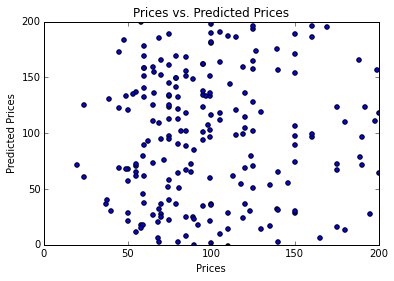

In [112]:
lin_reg(x_train, y_train, x_test, y_test)